The presentation slides [are here.](https://www.canva.com/design/DAGsB3IT0QM/Q9hxlQP4OHgTY0Rn3MH15g/edit?utm_content=DAGsB3IT0QM&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)

[*Double responding: A new constraint for models of speeded decision making*](https://www.sciencedirect.com/science/article/pii/S0010028520300219?via%3Dihub)

The data from the article [is here.](https://www.gillesdutilh.com/pages/materials_practice1.htm)


[**MODELS IN CODE**](https://osf.io/7jmb2/files/osfstorage).


[Bu](https://royalsocietypublishing.org/doi/epdf/10.1098/rspb.2016.0291?src=getftr&utm_source=sciencedirect_contenthosting&getft_integrator=sciencedirect_contenthosting) ne amina koyim?

***

## Key Findings

* The study shows that double responding creates several interesting benchmarks that can help distinguish between the predictions of different EAMs, even in standard experimental paradigms.

* When EAMs are constrained to account for both choice response time distributions and double responding behavior simultaneously, their predictions become more distinct.

* The findings suggest that models incorporating lateral inhibition (like the Leaky Competing Accumulator, or LCA, which was also present in your initial table) are generally better at making accurate predictions for this combined data.

* In contrast, models containing feed-forward inhibition (such as the Diffusion Model) performed poorly when extended to account for double responding, suggesting they might be less capable of accurately predicting these specific behavioral patterns.
> Why do some of the models work poorly and others work better introducing the constraints?

In [ ]:
!pip install bayesflow tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import bayesflow as bf
import numpy as np

In [ ]:
#@title SIMULATOR

def ddm_trial(
    v,       # Drift rate: average rate of evidence accumulation (float)
    a,       # Boundary separation: decision threshold (float)
    ter,     # Non-decision time: time for non-decisional processes (float)
    s=1.0,   # Diffusion coefficient (noise standard deviation): typically fixed to 1.0 (float)
    dt=0.001,# Time step size (in seconds, float)
    max_time=5.0 # Maximum simulation time (in seconds, float) to prevent infinite loops
):
    """
    Simulates a single trial of a Diffusion Decision Model (DDM).

    Parameters:
    -----------
    v : float
        Drift rate. Positive values favor the upper boundary, negative values favor the lower.
    a : float
        Boundary separation (threshold). Must be positive.
    ter : float
        Non-decision time (in seconds). Must be non-negative.
    s : float, optional
        Diffusion coefficient (noise standard deviation). Default is 1.0.
    dt : float, optional
        Time step size (in seconds). Default is 0.001.
    max_time : float, optional
        Maximum simulation time (in seconds). If no boundary is hit, returns NaN for RT.
        Default is 5.0.

    Returns:
    --------
    tuple: (response_time, decision)
        response_time : float
            The time (in seconds) it took to hit a boundary, plus non-decision time.
            Returns np.nan if max_time is reached without hitting a boundary.
        decision : int
            1 if upper boundary hit, -1 if lower boundary hit.
            0 if max_time is reached without hitting a boundary.
    """

    # Ensure boundaries are positive
    if a <= 0:
        raise ValueError("Boundary separation 'a' must be positive.")
    if ter < 0:
        raise ValueError("Non-decision time 'ter' cannot be negative.")
    if s <= 0:
        raise ValueError("Diffusion coefficient 's' must be positive.")
    if dt <= 0:
        raise ValueError("Time step 'dt' must be positive.")

    # Initialize accumulator
    evidence = 0.0

    # Iterate through time steps
    time = 0.0
    while time < max_time:
        # Generate random step based on drift and noise
        # np.random.normal(loc=mean, scale=std_dev)
        # Note: scale by sqrt(dt) because variance of Wiener process is proportional to time
        step = v * dt + np.random.normal(0, s * np.sqrt(dt))

        # Accumulate evidence
        evidence += step

        # Increment time
        time += dt

        # Check for boundary crossing
        if evidence >= a:
            return {"rt": time + ter, "resp": 1} # Decision for upper boundary
        elif evidence <= -a:
            return {"rt": time + ter, "resp": -1} # Decision for lower boundary

    # If max_time is reached without hitting a boundary
    return {"rt": np.NaN, "resp": 0} # No decision within max_time

In [ ]:
#@title PRIOR

# Define a random number generator for reproducibility if needed
RNG = np.random.default_rng() # If you want to use the new Generator API

def prior():
    """
    Generates a single random draw from the joint prior distribution for LCA parameters.

    Returns:
    --------
    dict
        A dictionary containing a single sample for each LCA parameter.
    """
    # Drift rates (v_0, v_1): Normal(loc=0.0, scale=1.5)
    v = RNG.normal(loc=0.0, scale=1.5)

    # Threshold (a): Uniform(low=0.5, high=2.5)
    a = RNG.uniform(low=0.5, high=2.5)

    ter = np.random.uniform(low=0.1, high=0.5)

    # Diffusion noise scale (s): Uniform(low=0.5, high=1.5)
    s = RNG.uniform(low=0.5, high=1.5)

    return {
        "v": v,
        "a": a,
        "ter": ter,
        "s": s
    }


In [ ]:
# --- Example Usage ---
if __name__ == "__main__":
    print("Example sampled parameters from the LCA prior function:")
    sampled_params = prior()
    for param_name, value in sampled_params.items():
        print(f"{param_name}: {value:.4f}")

    # To generate multiple samples (e.g., for Prior Predictive Checks):
    num_samples = 5
    print(f"\nGenerating {num_samples} sets of parameters:")
    for i in range(num_samples):
        params = prior()
        print(f"Sample {i+1}: {params}")


Example sampled parameters from the LCA prior function:
v: 0.5031
a: 2.0932
ter: 0.3226
s: 1.4911

Generating 5 sets of parameters:
Sample 1: {'v': 0.11139061108824963, 'a': 1.3831685178656417, 'ter': 0.34993638293500023, 's': 1.0864090502964978}
Sample 2: {'v': -0.686165256494288, 'a': 2.357666829218042, 'ter': 0.19200503708135602, 's': 1.230765958496408}
Sample 3: {'v': -2.0338509035064765, 'a': 0.6444850007028062, 'ter': 0.3686566340141565, 's': 1.233143640954887}
Sample 4: {'v': -0.19552793206481214, 'a': 0.8076077057586666, 'ter': 0.12711480264311162, 's': 0.8355977536903331}
Sample 5: {'v': 2.8821757412798092, 'a': 1.6429514206957765, 'ter': 0.1521208071144504, 's': 1.3938599485319045}


In [ ]:
simulator = bf.make_simulator([prior, ddm_trial])

In [ ]:
samples = simulator.sample(batch_size=5)
samples

{'v': array([[ 2.25032459],
        [ 1.06141284],
        [ 1.79689039],
        [-0.20861352],
        [ 0.84830961]]),
 'a': array([[2.07190145],
        [2.01896338],
        [2.1928379 ],
        [2.07996131],
        [1.31313592]]),
 'ter': array([[0.49067944],
        [0.33936372],
        [0.47915616],
        [0.27971967],
        [0.21129472]]),
 's': array([[0.65219645],
        [0.72982134],
        [0.75235371],
        [1.10872382],
        [0.59791474]]),
 'rt': array([[1.72867944],
        [2.36536372],
        [1.59215616],
        [2.18971967],
        [1.61929472]]),
 'resp': array([[ 1],
        [ 1],
        [ 1],
        [-1],
        [ 1]])}

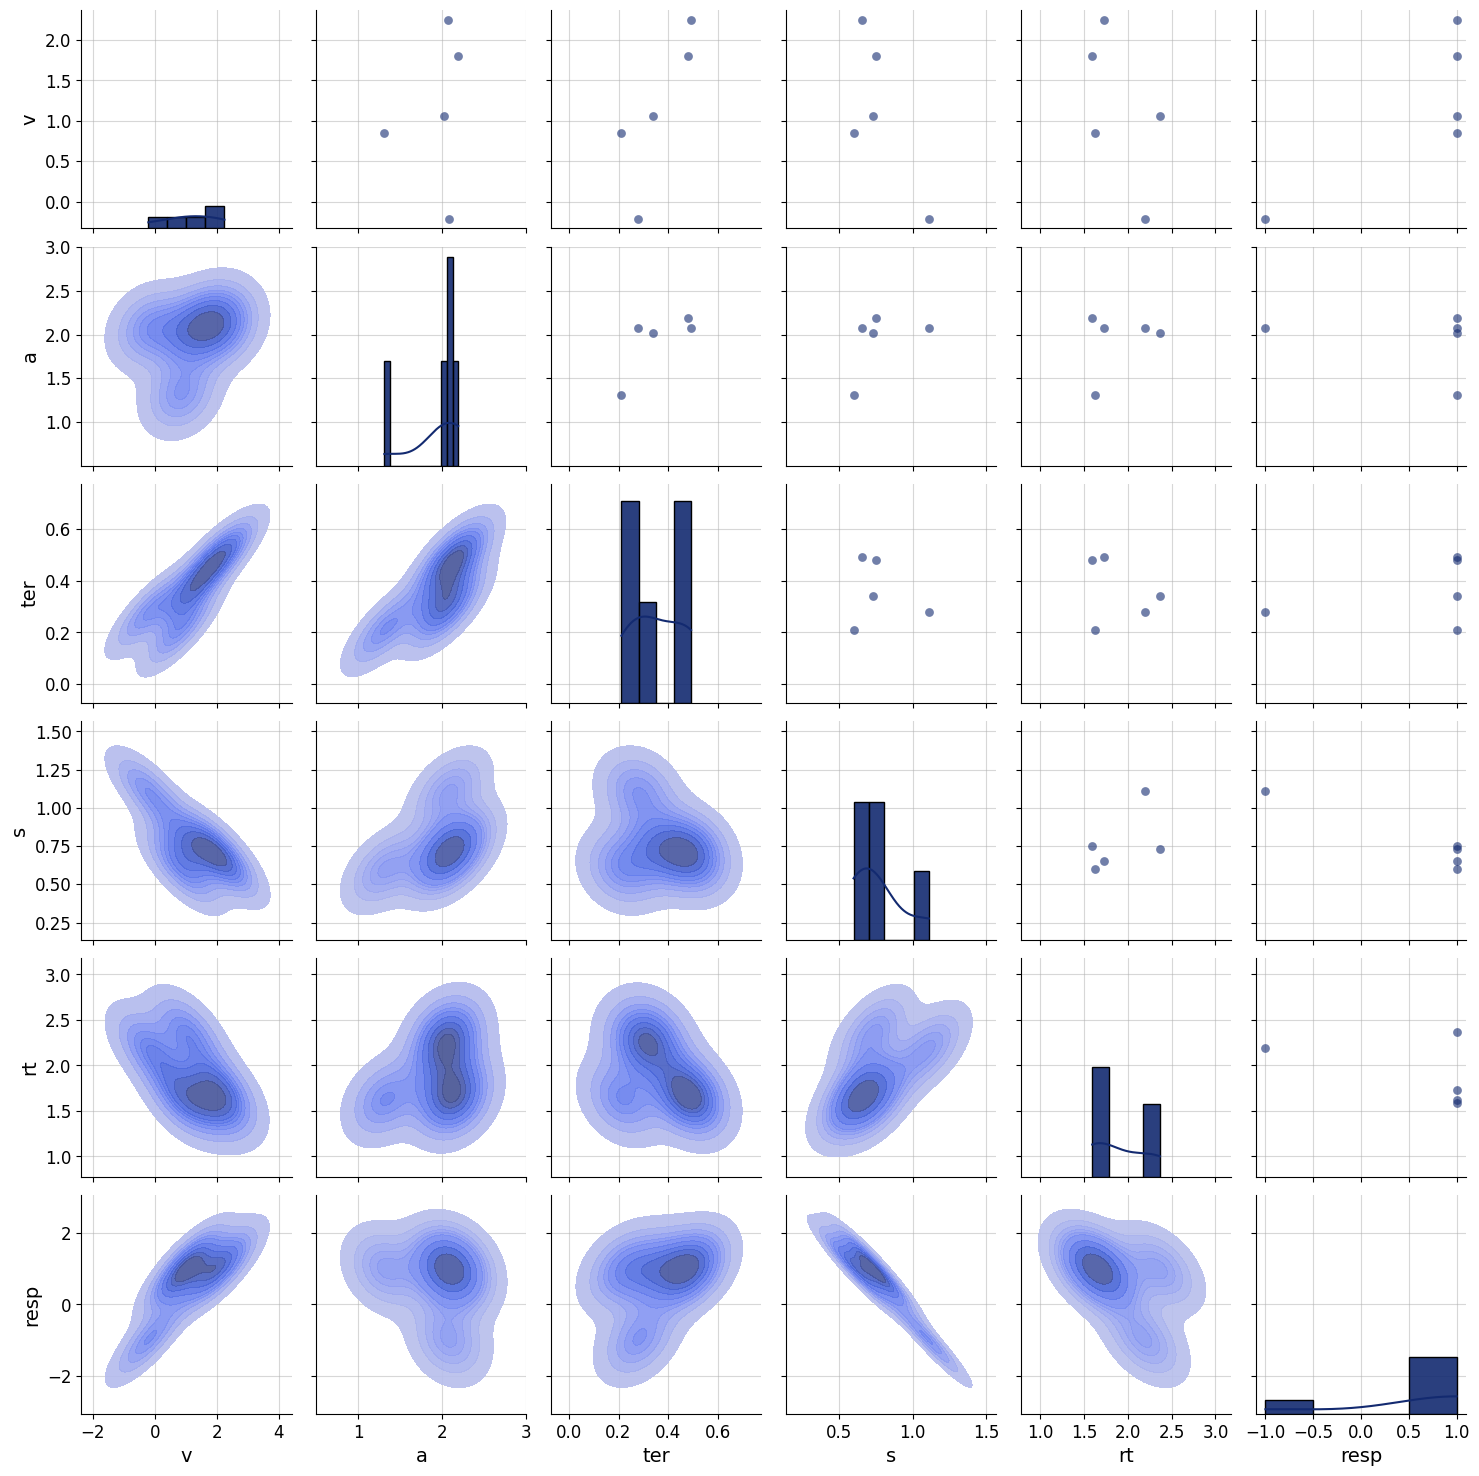

In [ ]:
f = bf.diagnostics.plots.pairs_samples(
    samples=samples
)

In [ ]:
adapter = (
    bf.Adapter()
    .concatenate(["v", "a", "ter", "s"], into="inference_variables")
)

In [ ]:
inference_network = bf.networks.CouplingFlow()

In [ ]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_network
)

In [ ]:
train_data = simulator.sample(batch_size=1_000)
validation_data = simulator.sample(batch_size=250)

In [ ]:
history = workflow.fit_offline(data=train_data, validation_data=validation_data, epochs=10, batch_size=64, num_batches_per_epoch=10)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - loss: 5.6976 - val_loss: 5.6886
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.6796 - val_loss: 5.6901
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6701 - val_loss: 5.6882
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.6826 - val_loss: 5.6847
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.6694 - val_loss: 5.6877
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6707 - val_loss: 5.6872
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6695 - val_loss: 5.6875
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6713 - val_loss: 5.6874
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.6696 - val_loss: 5.6871
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6723 - val_loss: 5.6872


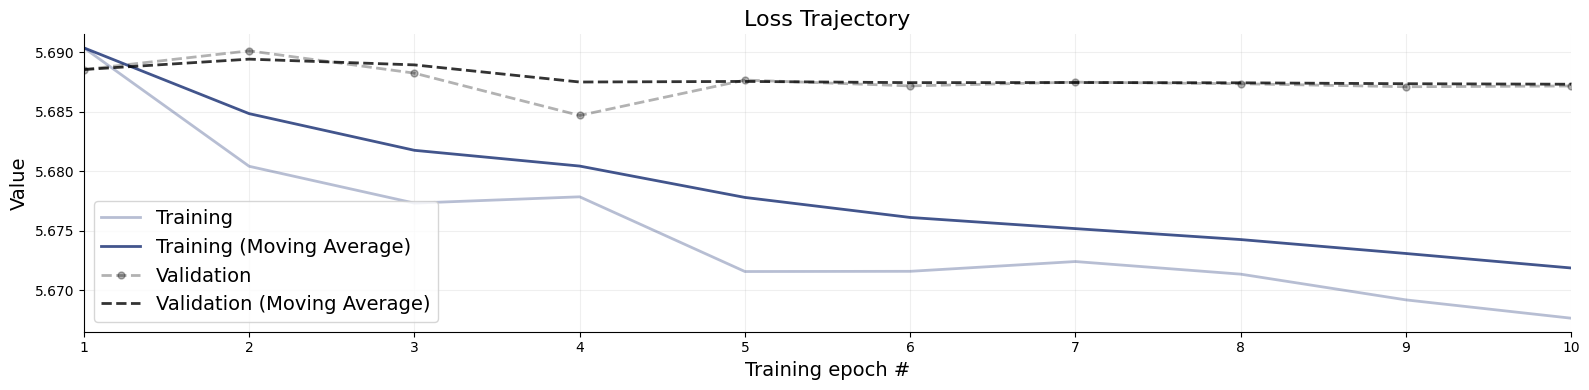

In [ ]:
f = bf.diagnostics.plots.loss(history)